Epoch [1/10], Loss: 0.0208
Epoch [2/10], Loss: 0.0065
Epoch [3/10], Loss: 0.0057
Epoch [4/10], Loss: 0.0054
Epoch [5/10], Loss: 0.0052
Epoch [6/10], Loss: 0.0050
Epoch [7/10], Loss: 0.0047
Epoch [8/10], Loss: 0.0048
Epoch [9/10], Loss: 0.0046
Epoch [10/10], Loss: 0.0045
Models saved as unet_encoder.pth and unet_decoder.pth


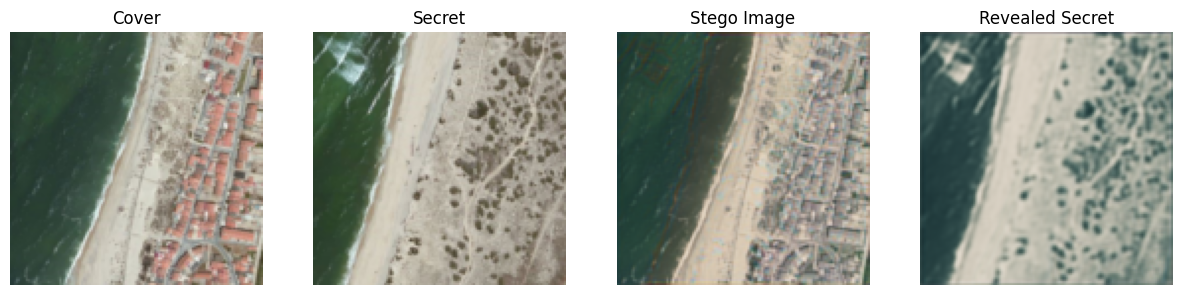

In [2]:
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

# --------------------- U-Net Encoder ---------------------
class UNetEncoder(nn.Module):
    def __init__(self):
        super(UNetEncoder, self).__init__()

        def conv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, 3, padding=1),
                nn.ReLU(inplace=True)
            )

        self.enc1 = conv_block(6, 64)
        self.pool1 = nn.MaxPool2d(2)

        self.enc2 = conv_block(64, 128)
        self.pool2 = nn.MaxPool2d(2)

        self.enc3 = conv_block(128, 256)
        self.pool3 = nn.MaxPool2d(2)

        self.enc4 = conv_block(256, 512)

        self.up2 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec2 = conv_block(512, 256)

        self.up3 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec3 = conv_block(256, 128)

        self.up4 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec4 = conv_block(128, 64)

        self.final = nn.Conv2d(64, 3, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, cover, secret):
        x = torch.cat([cover, secret], dim=1)

        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        e3 = self.enc3(self.pool2(e2))
        e4 = self.enc4(self.pool3(e3))

        d2 = self.dec2(torch.cat([self.up2(e4), e3], dim=1))
        d3 = self.dec3(torch.cat([self.up3(d2), e2], dim=1))
        d4 = self.dec4(torch.cat([self.up4(d3), e1], dim=1))

        out = self.sigmoid(self.final(d4))
        return out  # stego image

# --------------------- Simple Decoder ---------------------
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 3, 3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, stego):
        return self.decoder(stego)

# --------------------- Dataset ---------------------
class StegoDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.images = [os.path.join(folder_path, img) for img in os.listdir(folder_path)
                       if img.lower().endswith(('.jpg', '.png', '.jpeg'))]
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        cover_path = self.images[idx]
        secret_path = random.choice(self.images)

        cover = Image.open(cover_path).convert("RGB")
        secret = Image.open(secret_path).convert("RGB")

        if self.transform:
            cover = self.transform(cover)
            secret = self.transform(secret)

        return cover, secret

# --------------------- Train Function ---------------------
def train(encoder, decoder, dataloader, device, epochs=10):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=0.0002)

    for epoch in range(epochs):
        encoder.train()
        decoder.train()
        total_loss = 0

        for cover, secret in dataloader:
            cover = cover.to(device)
            secret = secret.to(device)

            stego = encoder(cover, secret)
            revealed = decoder(stego)

            loss_stego = criterion(stego, cover)
            loss_secret = criterion(revealed, secret)
            loss = loss_stego + loss_secret

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss / len(dataloader):.4f}")

    torch.save(encoder.state_dict(), "unet_encoder.pth")
    torch.save(decoder.state_dict(), "unet_decoder.pth")
    print("Models saved as unet_encoder.pth and unet_decoder.pth")

# --------------------- Utility ---------------------
def load_image(path, transform):
    if not os.path.exists(path):
        raise FileNotFoundError(f"Image not found: {path}")
    return transform(Image.open(path).convert("RGB")).unsqueeze(0)

def show_images(images, titles):
    fig, axs = plt.subplots(1, len(images), figsize=(15, 5))
    for i, (img, title) in enumerate(zip(images, titles)):
        axs[i].imshow(img.permute(1, 2, 0).detach().cpu().numpy())
        axs[i].set_title(title)
        axs[i].axis('off')
    plt.show()

# --------------------- Test ---------------------
def test(encoder, decoder, transform, device, cover_path, secret_path):
    cover = load_image(cover_path, transform).to(device)
    secret = load_image(secret_path, transform).to(device)

    encoder.eval()
    decoder.eval()

    with torch.no_grad():
        stego = encoder(cover, secret)
        revealed = decoder(stego)

    show_images([cover[0], secret[0], stego[0], revealed[0]],
                ["Cover", "Secret", "Stego Image", "Revealed Secret"])

# --------------------- Main ---------------------
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor()
    ])

    train_folder = r"C:\Users\dpriy\OneDrive\Desktop\ML_Project\images"
    test_cover = r"C:\Users\dpriy\OneDrive\Desktop\ML_Project\images\Image_1.png"
    test_secret = r"C:\Users\dpriy\OneDrive\Desktop\ML_Project\images\Image_2.png"

    if not os.path.exists(train_folder):
        raise FileNotFoundError(f"Training folder not found: {train_folder}")

    dataset = StegoDataset(train_folder, transform)
    dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

    encoder = UNetEncoder().to(device)
    decoder = Decoder().to(device)

    train(encoder, decoder, dataloader, device, epochs=10)

    encoder.load_state_dict(torch.load("unet_encoder.pth", map_location=device))
    decoder.load_state_dict(torch.load("unet_decoder.pth", map_location=device))

    test(encoder, decoder, transform, device, test_cover, test_secret)

# EVALUATION